### HOW TO RUN: ###


* Navigate to the folder icon on the left
* Click on the upload file icon
* Upload agg.csv, conf.ini, bestloss.txt, and best-model.keras from the github directory


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import configparser
import seaborn as sns

### TODOS: ###


*  Data preprocessing, visualize the relationship and choose the best ones (IN PROGRESS)
*  Show a graph that loss is reduced through training (DONE)
*  Add a metric for the model (DONE)








In [ ]:
def dropUnneeded(df, drop_non_correlated=False):
    df = df.drop("S&P OPEN", axis=1)
    df = df.drop("S&P HIGH", axis=1)
    df = df.drop("S&P LOW", axis=1)

    if drop_non_correlated:
        # List of non-correlated features to be dropped.
        non_correlated_features = [
                                  # < 0.25
                                  '4 Month T',
                                  'Mortgage 15 Yr',
                                  'ISent: Neutral',
                                  'UMich Consumer Sentiment',


                                  ]
        '''
        # Threshold for dropping non-correlated features
        threshold = 0.1  # or some other value close to 0

        # Identify non-correlated features
        non_correlated_features = corr_matrix.index[abs(corr_matrix['S&P CLOSE']) < threshold].tolist()
        '''
        # Drop the non-correlated features from the dataframe.
        df = df.drop(non_correlated_features, axis=1)

    return df


In [ ]:
# Returns a tuple of (df, dataX, dataY)
# Where df is the original dataframe, dataX is the formatted normalized input data,
# and dataY is the formatted normalized output data.
# The dataframe will not include the date column if df_dates is False.
def preprocess(n_past, n_future, label_column, null, df_dates=True, include_month_change=False, remove_label_from_input=False):
    # Load the data.
    # We'll forward fill any missing values, so long as there are no more than 5 of them consecutively,
    # then fill any remaining missing values with our null constant.
    df = pd.read_csv("./agg.csv").ffill(limit=5).fillna(null)
    df = dropUnneeded(df, drop_non_correlated=False)

    if (not include_month_change and 'S&P MONTH CHANGE' in df.columns):
        df = df.drop('S&P MONTH CHANGE', axis=1)

    # Remove date column temporarily; not useful for normalizing
    ddf = df.iloc[:, 1:]

    # Mean normalize (standardization)
    mean = ddf.mean()
    std = ddf.std()
    ddf = (ddf - mean) / std

    # Convert to numpy
    data = ddf.to_numpy()

    # Format the data to a 3D shape so the LSTM can use it.
    # The resulting shapes will be as follows:
    #    dataX: (number_of_input_series, number_of_timesteps, number_of_features)
    #    dataY: (number_of_input_series, 1)
    dataX = []
    dataY = []

    for i in range(n_past, len(data) - n_future + 1):
        dataX.append(data[i - n_past:i, 0:data.shape[1]])
        dataY.append(data[i + n_future - 1:i + n_future, label_column])

    # Remove date column permanently if requested
    if not df_dates:
        df = df.iloc[:, 1:]

    # Delete S&P change, price open and price close columns from input data.
    if remove_label_from_input:
        dataX = np.delete(dataX, label_column, axis=2)

    # Return a tuple containing (df, dataX, dataY)
    return (df,np.array(dataX),np.array(dataY))

## Config the model

In [ ]:
conf = configparser.ConfigParser()
conf.read("./conf.ini")

BATCH_SIZE = 2
LEARNING_RATE = 0.003#0.005
EPOCHS = 2
WEIGHT_DECAY = 0.004#0.002
ACTIVATION = "tanh"
L1_REG = 0.001;

In [ ]:
# The arbitrary null value for missing data.
null = int(conf['data']['null'])

# How many timesteps in the future we're predicting
n_future = int(conf['data']['n_future'])
# The size of each input series (in timesteps).
n_past = int(conf['data']['n_past'])
# The column index containing the output, AFTER removing the date column.
label_column = int(conf['data']['label_column'])
# Include the S&P percentage change (by about a month)
include_month_change = conf['data'].getboolean('include_month_change')
# Remove the label from the features
remove_label_from_input = conf['data'].getboolean('remove_label_from_input')

In [ ]:
# Load the data
df, dataX, dataY = preprocess(n_past, n_future, label_column, null, df_dates=False, include_month_change=include_month_change, remove_label_from_input=remove_label_from_input)

print(df.head())
print("Shape:", dataX.shape)

    S&P CLOSE  S&P VOLUME  VIX OPEN  VIX CLOSE  VIX HIGH  VIX LOW  1 Month T  \
0  105.760002    40610000    -100.0     -100.0    -100.0   -100.0     -100.0   
1  105.220001    50480000    -100.0     -100.0    -100.0   -100.0     -100.0   
2  106.519997    39130000    -100.0     -100.0    -100.0   -100.0     -100.0   
3  106.809998    44500000    -100.0     -100.0    -100.0   -100.0     -100.0   
4  108.949997    53390000    -100.0     -100.0    -100.0   -100.0     -100.0   

   2 Month T  3 Month T  4 Month T  ...  UMich Consumer Sentiment  \
0     -100.0     -100.0     -100.0  ...                      67.0   
1     -100.0     -100.0     -100.0  ...                      67.0   
2     -100.0     -100.0     -100.0  ...                      67.0   
3     -100.0     -100.0     -100.0  ...                      67.0   
4     -100.0     -100.0     -100.0  ...                      67.0   

   ISent: Bull  ISent: Neutral  ISent: Bear  Corporate Debt  MWEFT  \
0       -100.0          -100.0    

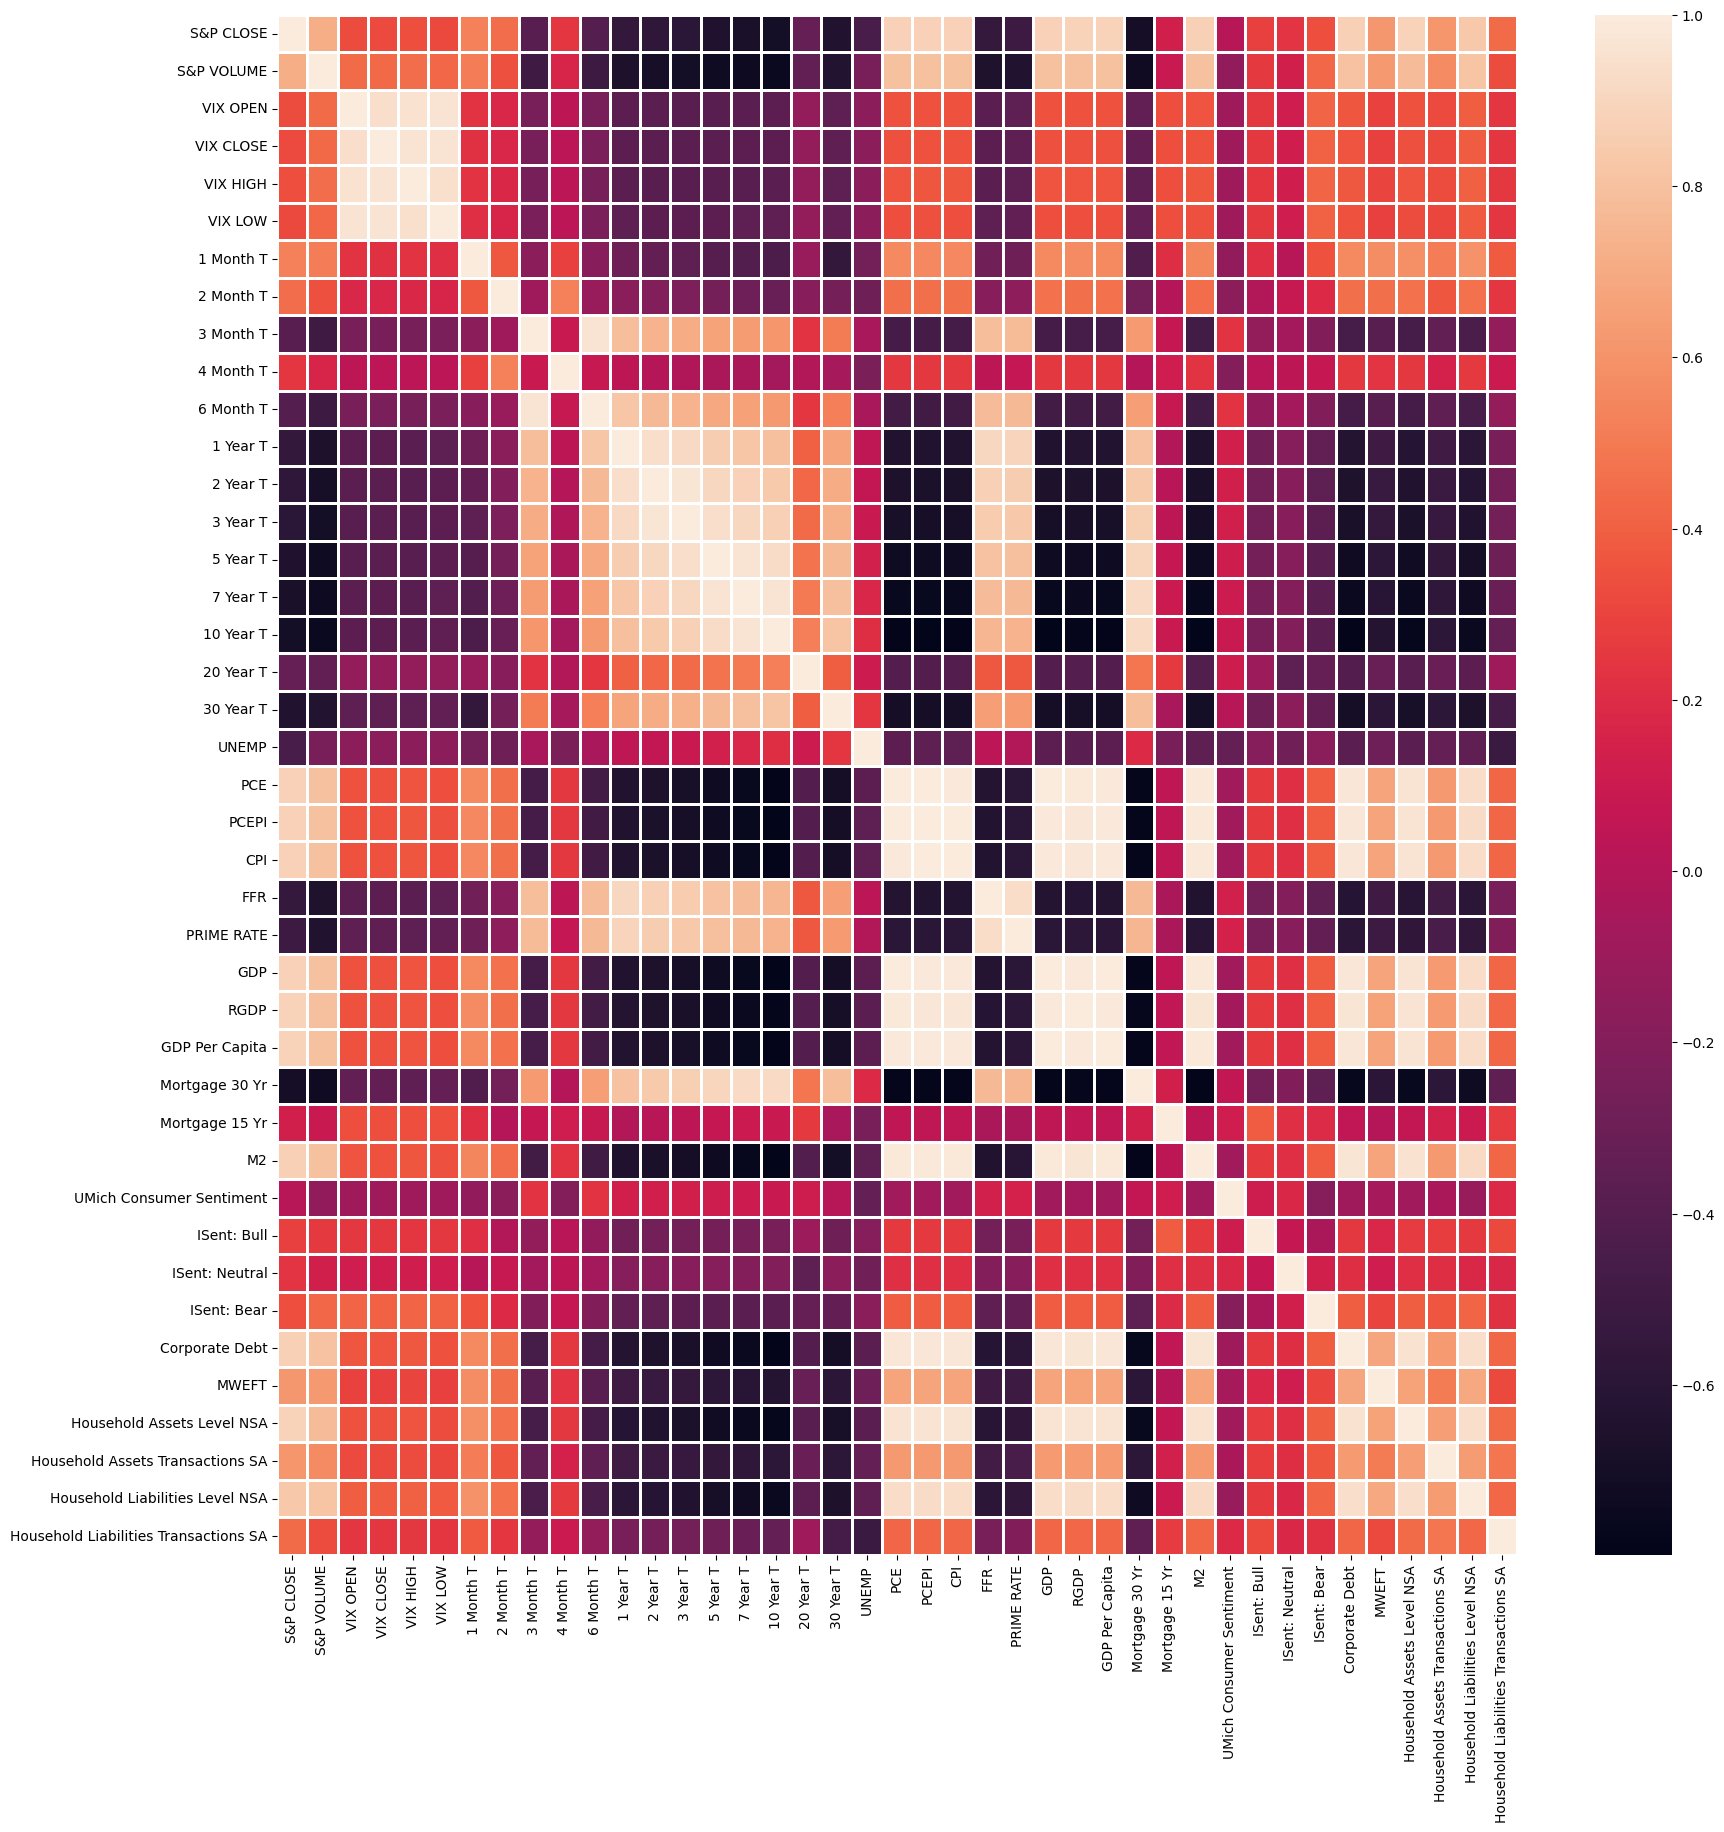

In [ ]:
corr_matrix = df.corr(method="kendall")
plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix, linewidths=2, xticklabels=True, yticklabels=True)
plt.show()

<Axes: >

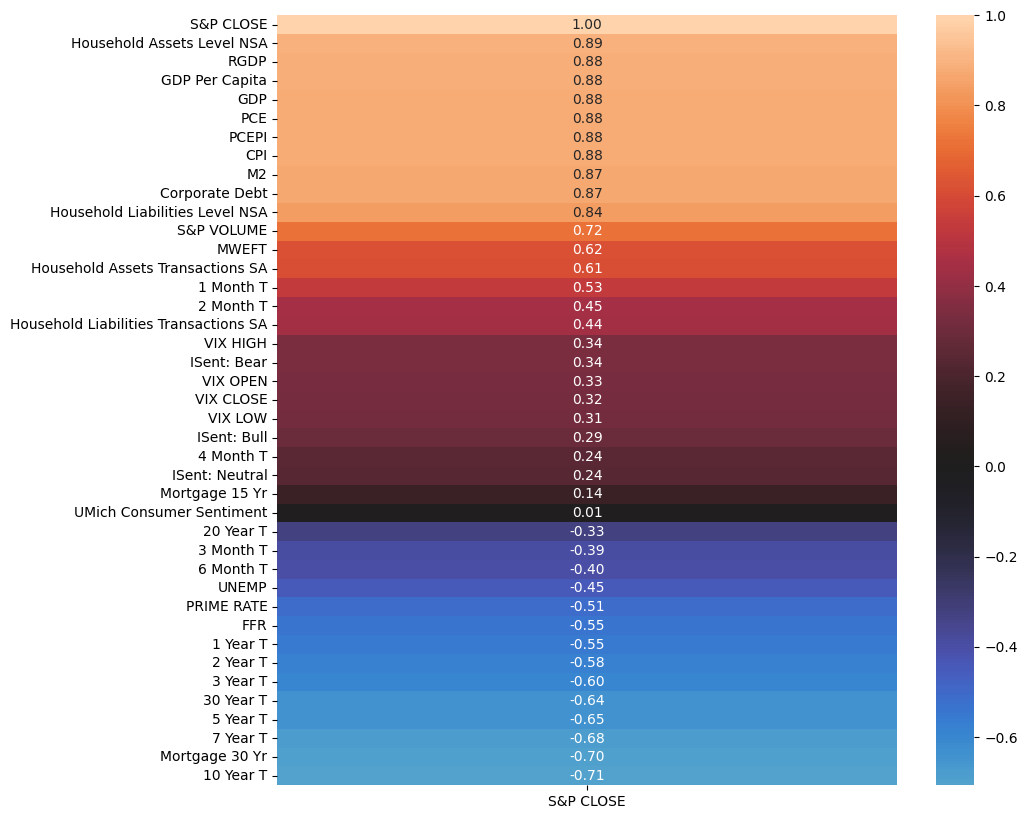

In [ ]:
label_correlations = corr_matrix['S&P CLOSE'].sort_values(ascending=False)
# label_matrix = corr_matrix[['S&P CLOSE']]
plt.figure(figsize=(10, 10))
# sns.heatmap(label_matrix, linewidths=2, xticklabels=True, yticklabels=True)
sns.heatmap(label_correlations.to_frame(), annot=True, fmt='.2f', center=0)

We can see from the Kendall correlation matrix that a few of our columns have a low correlation with our label (S&P Close). These include but are not limited to: VIX levels, 15 year mortgage rates, consumer sentiment, and investor sentiment.

We used Kendall Correlation due to its reputation of being a good coefficient for nonlinear data. While it isn't perfect, it's a good starting point for feature selection.

In [ ]:
mean = df.mean()
std = df.std()

In [ ]:
# Train test split
trainX, testX, trainY, testY = train_test_split(dataX, dataY, test_size=0.05, shuffle=False)

# Shuffle only the training data
trainRandomIndices = np.random.permutation(len(trainX))
trainX = trainX[trainRandomIndices]
trainY = trainY[trainRandomIndices]

In [ ]:
SHAPE = (dataX.shape[1],dataX.shape[2])

# Define the model
inputs = keras.Input(shape=SHAPE, dtype="float32", name="inputs")

x = layers.LSTM(25, return_sequences=True, activation=ACTIVATION, kernel_regularizer=regularizers.L1(L1_REG))(inputs)
# x = layers.LSTM(40, return_sequences=True, activation=ACTIVATION)(x)
x = layers.LSTM(25, return_sequences=False, activation=ACTIVATION)(x)

outputs = layers.Dense(1, name="outputs")(x) # activation="tanh",

model = keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(loss="mse", run_eagerly=False, optimizer=(tf.keras.optimizers.AdamW(learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY)), metrics=[keras.metrics.RootMeanSquaredError(), keras.losses.MeanAbsoluteError()])

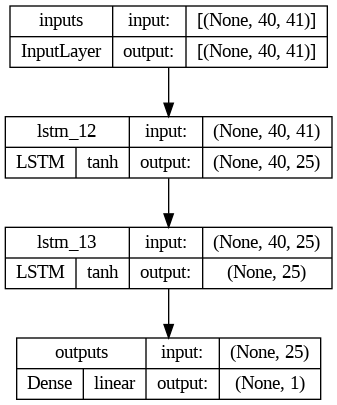

In [ ]:
# visualize the model
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png',show_layer_activations=True, show_shapes=True, show_layer_names=True)

In [ ]:
# Train the model
history = model.fit(trainX, trainY, epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True)

Epoch 1/2
5280/5280 [==============================] - 138s 24ms/step - loss: 0.0478 - root_mean_squared_error: 0.1191 - mean_absolute_error: 0.0671
Epoch 2/2
5280/5280 [==============================] - 131s 25ms/step - loss: 0.0241 - root_mean_squared_error: 0.0779 - mean_absolute_error: 0.0431


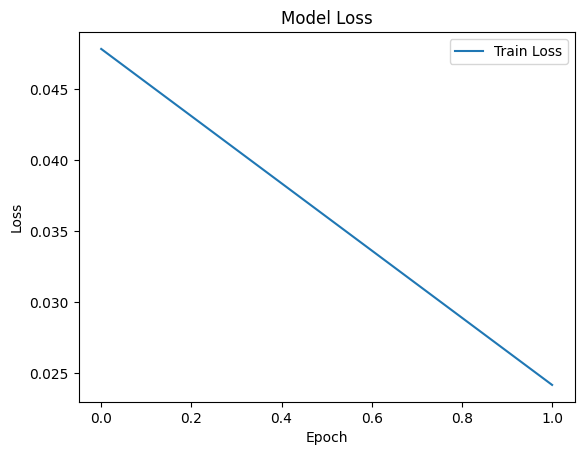

In [ ]:
# plot the loss
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

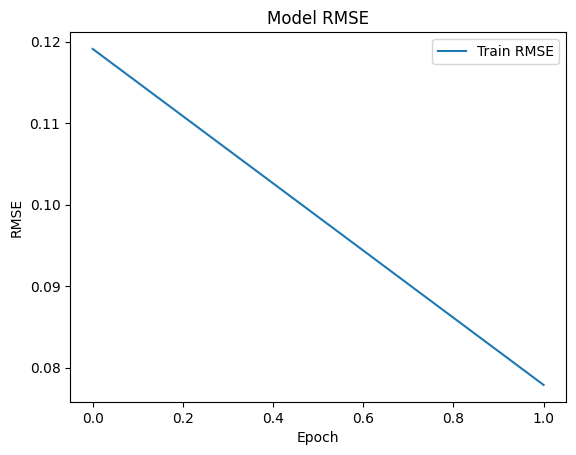

In [ ]:
# Plot training & validation RSME
plt.plot(history.history['root_mean_squared_error'], label='Train RMSE')
plt.title('Model RMSE')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

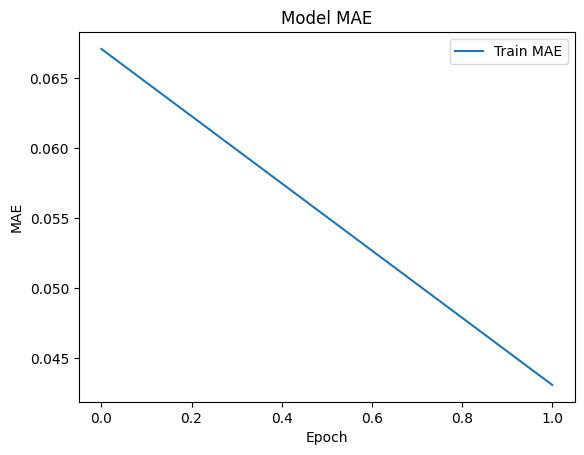

In [ ]:
# plot mae
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

In [ ]:
# Evaluate the model on the test data
train_loss = model.evaluate(trainX, trainY, verbose=0)
test_loss = model.evaluate(testX, testY, verbose=0)

print('Train Loss: ', train_loss)
print('Test Loss: ', test_loss)

Train Loss:  [0.003935318440198898, 0.024688927456736565, 0.01737738959491253]
Test Loss:  [0.01305178552865982, 0.09862053394317627, 0.08680836111307144]


## Compare current Loss and Model performance with previously trained model to update bessloss.txt file and best-model.keras

In [ ]:
bestlossr = open('bestloss.txt', 'r')
bestloss = bestlossr.read()

# Save the model if this is a new best loss ([0] = MSE)
if (not bestloss.replace(".", "").isnumeric()) or test_loss[0] < float(bestloss):
	print("New best loss! Saving model...")
	model.save("./best-model.keras")

	bestlossw = open('bestloss.txt', 'w')
	bestlossw.write(str(test_loss[0]))
	bestlossw.close()

	meanstd = open('meanstd.txt', 'w')
	meanstd.write(str(mean.to_list()) + "\n" + str(std.to_list()))
	meanstd.close()

else: print("Model not saved, best lost still", bestloss)

bestlossr.close()

New best loss! Saving model...


18/18 [==============================] - 1s 11ms/step
(556, 1)
(556, 1)
Predicted:  [4732.3623] Actual:  [4659.029785]
Predicted:  [4722.7393] Actual:  [4662.850098]
Predicted:  [4709.6753] Actual:  [4577.109863]
Predicted:  [4673.056] Actual:  [4532.759766]
Predicted:  [4629.793] Actual:  [4482.72998]
Predicted:  [4586.9116] Actual:  [4397.939941]
Predicted:  [4529.9453] Actual:  [4410.129883]
Predicted:  [4499.389] Actual:  [4356.450195]
Predicted:  [4476.308] Actual:  [4349.930176]
Predicted:  [4463.345] Actual:  [4326.509766]
Predicted:  [4450.733] Actual:  [4431.850098]
Predicted:  [4488.747] Actual:  [4515.549805]
Predicted:  [4552.822] Actual:  [4546.540039]
Predicted:  [4601.3784] Actual:  [4589.379883]
Predicted:  [4635.0083] Actual:  [4477.439941]
Predicted:  [4608.645] Actual:  [4500.529785]
Predicted:  [4580.0605] Actual:  [4483.870117]
Predicted:  [4561.2275] Actual:  [4521.540039]
Predicted:  [4570.081] Actual:  [4587.180176]
Predicted:  [4607.106] Actual:  [4504.080078]


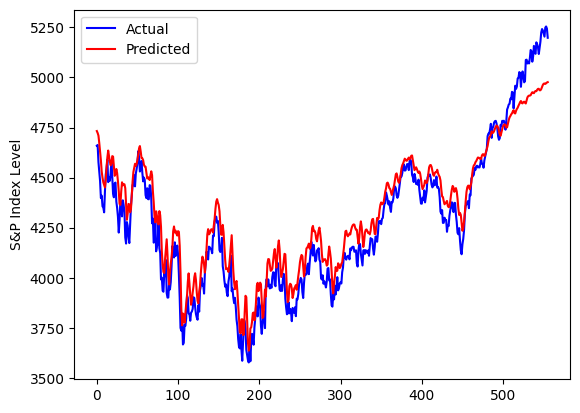

In [ ]:
# Plot the predicted graph movement
testYReg = testY * std[df.columns[label_column]] + mean[df.columns[label_column]]
testYHat = model.predict(testX) * std[df.columns[label_column]] + mean[df.columns[label_column]]

print(testYReg.shape)
print(testYHat.shape)

for i in range(0, len(testYHat)):
	print("Predicted: ", testYHat[i], "Actual: ", testYReg[i])

print("Train loss:", train_loss)
print("Test loss:", test_loss)

plt.plot(testYReg, c="blue", label="Actual")
plt.plot(testYHat, c="red", label="Predicted")

plt.ylabel("S&P Index Level")
plt.legend()
plt.show()

In [ ]:
# Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math

def mean_absolute_percentage_error(y_true, y_pred):
    # Convert inputs to numpy arrays for vectorized operation
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    # Avoid division by zero and only use non-zero elements for calculation
    mask = y_true != 0
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

mse = mean_squared_error(testYReg, testYHat)
mape = mean_absolute_percentage_error(testYReg, testYHat)
print("Root Mean Squared Error (MSE):", math.sqrt(mse))
print("Mean Absolute Percentage Error (MAPE): {:.2f}%".format(mape))

Root Mean Squared Error (MSE): 113.59123991353512
Mean Absolute Percentage Error (MAPE): 2.23%


In [ ]:
with open('log.csv', 'a') as logfile:
  # trainXLength, trainXTimesteps, trainXFeatures, Batch Size, Learning Rate, Epochs, Weight Decay, L1 Reg, Activation, layers, train MSE, test MSE, test RMSE, test MAE, test MAPE
  logfile.write(f"{trainX.shape[0]},{trainX.shape[1]},{trainX.shape[2]},{BATCH_SIZE},{LEARNING_RATE},{EPOCHS},{WEIGHT_DECAY},{L1_REG},{ACTIVATION},{len(model.layers)},")
  logfile.write(f"{train_loss[0]},{test_loss[0]},{test_loss[1]},{test_loss[2]},{mape}\n")